### CPS_PECERT_Mapper

September 1, 2019

Brian Dew @bd_econ

Map what share of each state's population has a professional certification.


In [1]:
# Import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap as Basemap

path = '/home/brian/Documents/CPS/data/clean/'

In [2]:
month, year = 6, 2021

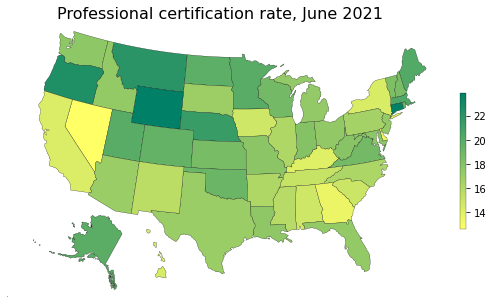

In [3]:
# Retrieve professional certification rate by state
cols = ['MONTH', 'STATE', 'CERT', 'BASICWGT']
s = (pd.read_feather(path + f'cps{year}.ft', columns=cols)
       .query('MONTH == @month and CERT in [0, 1]')
       .groupby('STATE')
       .apply(lambda x: np.average(x['CERT'], weights=x['BASICWGT']) * 100))

# Map values to colors
cm = plt.cm.summer_r
norm = Normalize(s.min(), s.max())

# Create map
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

fig = plt.figure(figsize=(10, 5))
lw = 0.25 # line width for borders

m.drawmapboundary()
m.readshapefile('shapefiles/states', 'states', drawbounds=False)

ax = plt.gca()
ax.axis('off')

for info, shape in zip(m.states_info, m.states):
    # Move and resize Hawaii and Alaska
    if info['STATE_NAME'] == 'Hawaii':
        shape = [(x + 5200000, y - 1400000) for x,y in shape]
    elif info['STATE_NAME'] == 'Alaska':
        shape = [(x*0.35 + 1100000, y*0.35 -1300000) for x,y in shape]
    fc = cm(norm(s[info['STATE_ABBR']]))
    ax.add_patch(Polygon(shape, fc=fc, ec='black', lw=lw))

date = pd.to_datetime(f'{year}-{month}-01').strftime('%B %Y')
plt.title(f'Professional certification rate, {date}', fontsize=16)
cb = fig.colorbar(ax.imshow([s.values], cm), shrink=0.5)
cb.outline.set_linewidth(lw)
plt.show()